In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import read_data
import gensim
from sklearn.decomposition import PCA

In [2]:
data_folder = 'data'
nrows = None
prior = read_data(data_folder=data_folder, nrows=nrows, read_prior=True)
train = read_data(data_folder=data_folder, nrows=nrows, read_train=True)

In [3]:
train['product_id'] = train['product_id'].astype('str')
prior['product_id'] = prior['product_id'].astype('str')

In [4]:
train_products = train.groupby('order_id')['product_id'].apply(lambda x: x.tolist()).reset_index()
prior_products = prior.groupby('order_id')['product_id'].apply(lambda x: x.tolist()).reset_index()

In [5]:
products = pd.concat([train_products, prior_products])
print(products.shape)

(3346083, 2)


In [6]:
products.head()

,order_id,product_id
0,1,"[49302, 11109, 10246, 49683, 43633, 13176, 472..."
1,36,"[39612, 19660, 49235, 43086, 46620, 34497, 486..."
2,38,"[11913, 18159, 4461, 21616, 23622, 32433, 2884..."
3,96,"[20574, 30391, 40706, 25610, 27966, 24489, 39275]"
4,98,"[8859, 19731, 43654, 13176, 4357, 37664, 34065..."


In [7]:
max_num_prods= len(max(products['product_id'], key=len))
max_num_prods

145

In [8]:
# model training
model = gensim.models.Word2Vec(sentences=products['product_id'], min_count=2, vector_size=100, window=max_num_prods, workers=8)

In [21]:
model.save('data/word2vec.model')

- `min_count` = 2 to ignore orders with only one product inside
- vector_size = 100, default size for the word vectors
- window =  max_num_prods because sequence of products added to cart are independent

In [9]:
model.wv.vectors.shape

(49583, 100)

In [10]:
len(model.wv.key_to_index.keys())

49583

In [11]:
model.wv

In [12]:
prods_embedding = pd.DataFrame(index=model.wv.key_to_index.keys(),
                              data=model.wv.vectors).rename_axis('product_id')
prods_embedding.head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
product_id,,,,,,,,,,,,,,,,,,,,,
24852,3.240155,-0.814828,-1.009469,0.808219,-1.052866,2.631171,-1.241534,0.821271,2.797932,-1.450928,...,-1.994438,-4.731552,-3.783216,0.440279,-7.281581,-2.227767,0.476216,3.264765,0.671357,3.831982
13176,3.505543,1.815684,1.599661,-0.264513,1.117413,3.136415,-1.204752,-0.527119,2.194315,-0.053540,...,-2.996011,-2.497301,-5.272954,1.948144,-6.026057,-4.122658,-4.169160,7.842493,-1.113192,3.626555
21137,-0.277477,0.370455,-3.224723,0.924037,0.707349,-4.643426,-1.090670,-0.373300,4.111485,3.704359,...,-0.174097,1.834221,-1.536483,-1.072964,-5.756443,-3.475915,-3.152087,1.732230,0.000837,-0.779622


In [13]:
def get_product_names(dic, pid):
    products=pd.read_pickle('data/products.pickle')[['product_id', 'product_name', 'aisle', 'department']]
    products['product_id'] = products['product_id'].astype('str')
    print(products.loc[products['product_id']==pid])
    return pd.DataFrame(dic, columns=['product_id', 'similarity']).merge(products)

In [23]:
pid = '24852'
dic = model.wv.most_similar(pid, topn=5)
get_product_names(dic, pid)

      product_id product_name         aisle department
24851      24852       Banana  fresh fruits    produce


,product_id,similarity,product_name,aisle,department
0,13176,0.791355,Bag of Organic Bananas,fresh fruits,produce
1,37067,0.583718,Organic Banana,fresh fruits,produce
2,4920,0.456135,Seedless Red Grapes,packaged vegetables fruits,produce
3,18870,0.445688,Pure-Castile Soap,soap,personal care
4,41787,0.438475,Bartlett Pears,fresh fruits,produce


Top 5 products most similar to Banana are:
- Bag of Organic Bananas,
- Organic Banana
- Bartlett Pears
- Seedless Red Grapes
- Lentil & Quinoa Spaghetti

Because the model is trained based on orders of products, the top similar products can be alternatives for customers

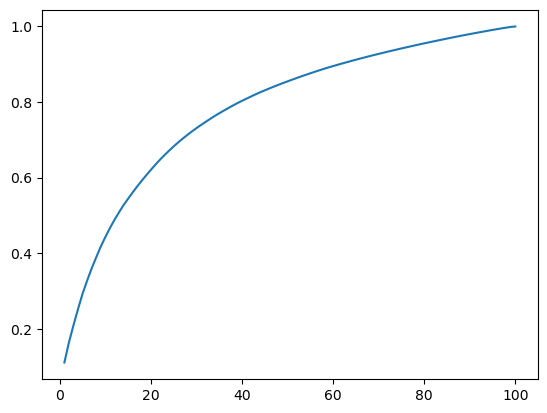

In [15]:
# to choose how many components we need
full_variance_explained = PCA().fit(prods_embedding.values).explained_variance_ratio_
plt.plot(range(1, prods_embedding.shape[1]+1, ), full_variance_explained.cumsum())

choose ~ 40 components to retain 80% of variance

In [16]:
var_retained = 0.6
n_components = np.argmax(np.cumsum(full_variance_explained) >= var_retained) + 1
n_components

19

In [17]:
# pca project data
pc = PCA(n_components, random_state=0).fit_transform(prods_embedding.values)
pc.shape

(49583, 19)

In [18]:
product_embedding = pd.DataFrame(index=prods_embedding.index, data=pc, columns=np.arange(pc.shape[1])).add_prefix('p_embedding_').reset_index()
product_embedding.head()

,product_id,p_embedding_0,p_embedding_1,p_embedding_2,p_embedding_3,p_embedding_4,p_embedding_5,p_embedding_6,p_embedding_7,p_embedding_8,p_embedding_9,p_embedding_10,p_embedding_11,p_embedding_12,p_embedding_13,p_embedding_14,p_embedding_15,p_embedding_16,p_embedding_17,p_embedding_18
0,24852,6.049557,-8.130088,0.018596,6.875715,7.495923,6.216565,-0.370873,4.601676,0.575752,-2.012782,-0.582063,0.514722,1.120727,-1.229528,0.513221,0.641563,-1.518985,0.113287,-2.933996
1,13176,12.470158,-1.704334,0.072343,5.253304,2.097081,-0.755644,3.216786,3.447232,0.486502,-0.457143,-0.422156,0.979682,1.510663,-1.292960,0.905670,-1.181042,0.979282,-0.639094,-0.737839
2,21137,13.077903,-5.658292,1.629294,5.378038,5.362668,-1.129243,2.544068,2.926641,0.125844,-1.978158,-1.205909,1.376146,-0.487320,-0.611201,-0.305478,-0.898842,-1.509129,0.986313,0.024391
3,21903,15.958419,-4.710447,-1.137028,-2.539438,2.741052,4.508426,0.585827,1.987267,1.739174,-1.213676,1.338500,2.542121,0.024626,-2.068274,0.195086,2.276981,-0.839333,0.893999,0.057966
4,47209,17.073814,-0.365114,-0.963488,2.121872,1.753384,1.333855,2.311964,1.642996,0.381703,-0.774548,-0.670450,1.749778,1.251452,-1.292340,-0.367877,-2.007529,0.141097,0.640995,0.027022


In [19]:
# convert produc
product_embedding.product_id = product_embedding.product_id.astype(int)

In [20]:
product_embedding.to_pickle('data/product_embedding.pickle')